In [10]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j,wigner_6j
import lmfit
from lmfit import Parameters,minimize


In [2]:
def kronecker(a,b):         # Kronecker delta function
    if a==b:
        return 1
    else:
        return 0

def b2a_matrix(a,b,S=1/2):
    if not kronecker(a['K'],b['K'])*kronecker(a['J'],b['J'])*kronecker(a['F'],b['F'])*kronecker(a['M'],b['M']):
        return 0
    else:
        if 'F1' in b.keys():
            if not kronecker(a['F1'],b['F1']):
                return 0
        return (-1)**(b['N']-S+a['P'])*np.sqrt(2*b['N']+1)*wigner_3j(a['J'],S,b['N'],a['P'],-a['Sigma'],-a['K'])
    
def convert_abBJ(input_qnumbers,output_qnumbers,S=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size))
    for i in range(output_size):
        for j in range(input_size):
            if 'N' in input_keys: #Convert case (b) to (a)
                a_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            else:
                b_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                a_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i,j] = b2a_matrix(a_qnumbers,b_qnumbers,S=S)
    return basis_matrix

def q_numbers_even_bBJ(N_range,K_mag,S=1/2,I_list=[0,1/2],M_values='all',M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','N','J','F','M']
    I = max(IM,iH)
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    for N in np.arange(Nmin,Nmax+1,1):
        for J in np.arange(abs(N-S),abs(N+S)+1,1):
            for F in np.arange(abs(J-I),abs(J+I)+1,1):
                if M_values=='none':
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        M=abs(F)%1
                        values = [K,N,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                else:
                    if M_values=='all' or M_values=='custom':
                        Mmin = -F
                    elif M_values=='pos':
                        Mmin = abs(F) % 1
                    for M in np.arange(Mmin,F+1,1):
                        if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                values = [K,N,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                        elif M_values=='custom' and M not in M_range:
                            continue
    return q_numbers

def q_numbers_even_aBJ(N_range,K_mag=1,S=1/2,I_list=[0,1/2],M_values='all',P_values=[1/2],M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    Jmin = abs(Nmin-S)
    Jmax = abs(Nmax+S)
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','Sigma','P','J','F','M']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    I = max(IM,iH)
    for J in np.arange(Jmin,Jmax+1,1):
        for F in np.arange(abs(J-I),abs(J+I)+1,1):
            if M_values=='none':
                for Sigma in np.arange(-abs(S),abs(S)+1,1):
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        P=K+Sigma
                        if abs(P) not in P_values:
                            continue
                        elif J < abs(P):
                            continue
                        else:
                            M=abs(F)%1
                            values = [K,Sigma,P,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
            else:
                if M_values=='all' or M_values=='custom':
                    Mmin = -F
                elif M_values=='pos':
                    Mmin = abs(F) % 1
                for M in np.arange(Mmin,F+1,1):
                    if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                        for Sigma in np.arange(-abs(S),abs(S)+1,1):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                P=K+Sigma
                                if abs(P) not in P_values:
                                    continue
                                elif J < abs(P):
                                    continue
                                else:
                                    values = [K,Sigma,P,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                    elif M_values=='custom' and M not in M_range:
                        continue
    return q_numbers

def write_state(vector,qn,case):
    for index in np.nonzero(vector)[0]:
        v={q:qn[q][index] for q in qn}
        coeff = vector[index]
        if case == 'bBS':
            print(' {} |K={},N={},G={},F1={},F={},M={}> \n'.format(coeff,v['K'],v['N'],v['G'],v['F1'],v['F'],v['M']))
        elif case == 'bBJ':
            print(' {} |K={},N={},J={},F={},M={}> \n'.format(coeff,v['K'],v['N'],v['J'],v['F'],v['M']))
        elif case == 'aBJ':
            print(' {} |K={},\u03A3={},P={},J={},F={},M={}> \n'.format(coeff,v['K'],v['Sigma'],v['P'],v['J'],v['F'],v['M']))

In [3]:
def q_numbers_A010(J,l=1,L=1,S=1/2,P_values=[1/2,3/2,5/2]):
    q_str = ['K','Lambda','l','P','J','Par']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    for K in [abs(L-l),abs(L+l)]:
        for P in [abs(K-S),abs(K+S)]:
            if abs(P) not in P_values:
                continue
            elif J < abs(P):
                continue
            else:
                for parity in [1,-1]:
                    values = [K,L,l,P,J,parity]
                    for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)
    return q_numbers

In [4]:
q_numbers_A010(3/2)

{'K': [0, 0, 0, 0, 2, 2],
 'Lambda': [1, 1, 1, 1, 1, 1],
 'l': [1, 1, 1, 1, 1, 1],
 'P': [0.5, 0.5, 0.5, 0.5, 1.5, 1.5],
 'J': [1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
 'Par': [1, -1, 1, -1, 1, -1]}

There are two papers with effective Hamiltonians.
Earlier is the SrOH paper:
https://aip.scitation.org/doi/10.1063/1.468171

And later on is the CaOH paper:
https://aip.scitation.org/doi/10.1063/1.468643

The CaOH result has gK

In [5]:
params_A010 ={
    'Tev': 16360.3890,
    'A': 67.0951,
    'ADdelt': 0.1232e-3,
    'ADsig': 0.140e-2,
    'AH': -0.140e-6,
    'ew2': -36.2634,
    'eDw2': 0.741e-3,
    'gK': 0.5937,
    'Bdelt': 0.3402609,
    'Bsig': 0.3402123,
    'Ddelt': 0.3976e-6,
    'Dsig': 0.399e-6,
    'gam': 0.02617,
    'gamD': -0.119e-4,
    'pe': -0.04472,
    'qe': -0.3072e-3,
    'qv': -0.6978e-3,
    'eps': -0.099,
}

def CaOH_A010(J,ef_parity,params):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2
    p=params
    
    Tev = p['Tev']
    gK = p['gK']
    eps = p['eps']
    A = p['A']
    ADd = p['ADdelt']
    ADs = p['ADsig']
    AH = p['AH']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    Bd = p['Bdelt']
    Bs = p['Bsig']
    Dd = p['Ddelt']
    Ds = p['Dsig']
    g = p['gam']
    gD = p['gamD']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    
    if J>3/2:
        H[0,0] = Tev + 2*gK - 3/4*eps*ew2 + 1/2*A*(1-3/4*eps**2) + (Bd + 1/2*ADd)*(z-6) - (Dd - 1/2*AH*0)*(z**2 - 11*z + 32) - 1/2*g - 0*gD*(z-5)
        H[0,1] = -(Bd - 1/2*g)*(z-4)**(1/2) + 2*Dd*(z-4)**(3/2) + 0*1/2*gD*(z-3)*(z-4)**(1/2)
        H[0,2] = 1/2*qv*(z**2 - 5*z + 4)**(1/2)
        H[0,3] = ef_parity*1/2*qe*(z**2 - 5*z + 4)**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = Tev + 2*gK - 3/4*eps*ew2 - 1/2*A*(1-3/4*eps**2) + (Bd - 1/2*ADd)*(z-2) - (Dd + 1/2*AH*0)*z*(z-3) - 1/2*g - 0*gD*(z-3)
        H[1,2] = (ef_parity*1/2*qe*z**(1/2) - qv)*(z-1)**(1/2) #Ambiguity on this term between SrOH and CaOH
        H[1,3] = (-ef_parity*1/2*(pe + 2*qe) + 1/2*qv*z**(1/2))*(z-1)**(1/2)
        H[2:,1] = H[1,2:]
    H[2,2] = Tev - 1/4*eps*ew2 + 1/2*A*(1-1/4*eps**2) + (Bs + 1/2*ADs)*z - (Ds - 1/2*AH)*(z**2 + z) - ef_parity*eDw2*z**(1/2) - 1/2*g - gD*z
    H[2,3] = ef_parity*ew2 - (Bs - 1/2*g)*z**(1/2) + 2*Ds*z**(3/2) + ef_parity*eDw2*z + 1/2*gD*(z+1)*z**(1/2)
    H[3,2] = H[2,3]
    H[3,3] = Tev - 1/4*eps*ew2 - 1/2*A*(1-1/4*eps**2) + (Bs - 1/2*ADs)*z - (Ds + 1/2*AH)*(z**2 + z) - ef_parity*eDw2*z**(1/2) - 1/2*g - gD*z
    
    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

def A010(J,parity,params):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2 - 1
    p=params
    
    w2 = p['w2']
    gK = p['gK']
    e = p['eps']
    A = p['A']
    w2 = p['w2']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    B = p['B']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    pv = p['pv']
    gm = p['gamma']
    
    if J>3/2:
        H[0,0] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 - A)) + 1/2*A + B*(z - 4) - D*(z**2 - 7*z + 13)
        H[0,1] = -(z - 3)**(1/2)*(B - 1/2*gm - 2*D*(z-2))
        H[0,2] = 1/2*qv*(z*(z - 1))**(1/2)
        H[0,3] = parity*(-1)**(J-1/2)*1/2*qe*(z*(z-3))**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + B*z - D*(z**2+z-3)
        H[1,2] = parity*(-1)**(J-1/2)*qe*(z*(z+1))**(1/2) + 1/2*(pv+ 2*qv)*z**(1/2)
        H[1,3] = -parity*(-1)**(J-1/2) * 1/2*(pe + 2*qe)*z**(1/2) - 1/2*qv*(z*(z+1))**(1/2)
        if depert:
            H[1,3]=0
        H[2:,1] = H[1,2:]
    H[2,2] = 2*w2 - (ew2)**2/(2*(2*w2 - A)) + 1/2*A + parity*(-1)**(J-1/2)*eDw2 * (J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    H[2,3] = -(z+1)**(1/2)*(B - gm/2 -2*D*(z+2)) - parity*(-1)**(J-1/2)*ew2*(1+((ew2)**2*(8*w2**2 - 6*A**2))/(4*(4*w2**2-A**2))) - parity*(-1)**(J-1/2)*eDw2*(z+2)
    H[3,2] = H[2,3]
    H[3,3] = 2*w2 - (ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + parity*(-1)**(J-1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    
    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

There is also the effective Hamiltonian form in the Brown computational molecular physics chapter. Let's use that, it's specifically for large spin-orbit

In [8]:
def A010(J,parity,params,depert=False):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2 - 1
    p=params
    
    w2 = p['w2']
    gK = p['gK']
    A = p['A']
    w2 = p['w2']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    B = p['B']
    D = p['D']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    pv = p['pv']
    gm = p['gamma']
    
    ecorr = 1+1/4*ew2**2*((8*w2**2-6*A**2)/(4*w2**2-A**2)**2)
    if J>3/2:
        H[0,0] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 - A)) + 1/2*A + B*(z - 4) - D*(z**2 - 7*z + 13)
        H[0,1] = -(z - 3)**(1/2)*(B - 1/2*gm - 2*D*(z-2))
        H[0,2] = -1/2*qv*(z*(z - 1))**(1/2)
        H[0,3] = parity*(-1)**(J-1/2)*1/2*qe*(z*(z-3))**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + B*z - D*(z**2+z-3)
        H[1,2] = parity*(-1)**(J-1/2)*qe*(z*(z+1))**(1/2) + 1/2*(pv+ 2*qv)*z**(1/2)
        H[1,3] = -parity*(-1)**(J-1/2) * 1/2*(pe + 2*qe)*z**(1/2) - 1/2*qv*(z*(z+1))**(1/2)
        if depert:
            H[1,3]=0
        H[2:,1] = H[1,2:]
    H[2,2] = 2*w2 - (ew2)**2/(2*(2*w2 - A)) + 1/2*A + parity*(-1)**(J-1/2)*eDw2 * (J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    H[2,3] = -(z+1)**(1/2)*(B - gm/2 -2*D*(z+2)) - parity*(-1)**(J-1/2)*ew2*ecorr - parity*(-1)**(J-1/2)*eDw2*(z+2)
    H[3,2] = H[2,3]
    H[3,3] = 2*w2 - (ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + parity*(-1)**(J-1/2)*eDw2*(J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

In [15]:
params = Parameters()
params.add('w2', value=330,vary=False)
params.add('A', value=1250,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=1e-5,vary=False)
params.add('B', value=0.254,min=0.2,max=0.3,vary=False)
params.add('pe',value=-0.5,min=-5,max=0,vary=True)
params.add('qe',value=0.001,min=-1,max=1,vary=False)
params.add('pv',value=-0.01,min=-5,max=5,vary=True)
params.add('qv',value=-0.001,min=-1,max=1,vary=False)
params.add('gK',value=0.2725,min=-1,max=5,vary=True)
params.add('gamma',-0.03,min=-5,max=5, vary=True)
params.add('ew2',-20,min=-50,max=0, vary=True)

In [14]:
Hp = A010(3/2,1,params_A010)
Hm = A010(3/2,-1,params_A010)
valsp,vecsp = np.linalg.eigh(Hp)
valsm,vecsm = np.linalg.eigh(Hm)

KeyError: 'w2'

In [ ]:
valsp

In [7]:
sub_B = False

plt.figure(figsize=(15,10))
for J in np.arange(1/2,4):
    Hp = A010(J,1,params_A010)
    Hm = A010(J,-1,params_A010)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    print((vals_p-vals_m)*29979.2458)
    _J = [J for val in vals_p]
    [plt.hlines(y=val,color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val)) for val in vals_p]
    [plt.hlines(y=val,color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.annotate(f'{J}-',(-0.55,val)) for val in vals_m]

plt.ylim(33,40)
plt.xlim(-1,1)

NameError: name 'params_A010' is not defined

<Figure size 1080x720 with 0 Axes>

In [24]:
def A010_resid(params,data_p,data_m,Jmax=5/2,uncertainty = 0.001,no_uncert = False):
    theory_p = []
    theory_m = []
    for J in np.arange(1/2,Jmax+1):
        HJp = A010(J,1,params)
        HJm = A010(J,-1,params)
        vals_p,vecs_p = np.linalg.eigh(HJp)
        vals_m,vecs_m = np.linalg.eigh(HJm)
        if J==1/2:
            theory_p.append(vals_p.min())
            theory_m.append(vals_m.min())
        else:
            theory_p.append(sorted(vals_p)[0])
            theory_p.append(sorted(vals_p)[1])
            theory_m.append(sorted(vals_m)[0])
            theory_m.append(sorted(vals_m)[1])
    all_data  = np.concatenate((data_p,data_m))
    all_data-=all_data.min()
    all_theory = np.concatenate((theory_p,theory_m))
    all_theory-=all_theory.min()
    if no_uncert:
        uncertainty=1
    resid = (all_data - all_theory)/uncertainty
    return resid

In [25]:
data_p = [17651.4518,17651.8629,17652.6354,17652.8624,17654.1187]
data_m = [17651.4685,17651.8466,17652.6182,17652.8845,17654.1463]

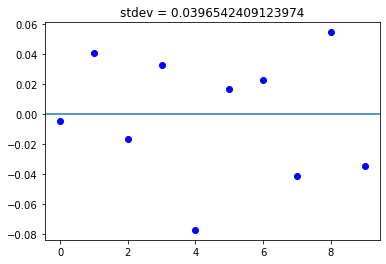

In [26]:


initial_resid = A010_resid(params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(initial_resid.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1250     -inf      inf     None    False     None     None
B         0.254      0.2      0.3     None    False     None     None
D             0     -inf      inf     None    False     None     None
eDw2          0     -inf      inf     None    False     None     None
ew2      -3.919     -100      100     None     True     None     None
gK       0.2725        0        1     None    False     None     None
gamma     3.152       -5        5     None     True     None     None
pe       -0.469       -5        0     None     True     None     None
pv        1.291       -5        5     None     True     None     None
qe         0.01       -1        1     None    False     None     None
qv       -0.001       -1        1     None    False     None     None
w2          330     -inf      inf     None    False     None     None


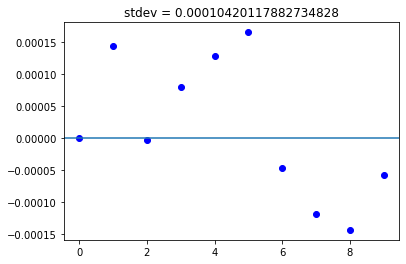

In [27]:
out = minimize(A010_resid, params, args=([data_p,data_m]),method='powell')#,kws={'flist':True})#,method='least_squares')
out.params.pretty_print()
final_resid = A010_resid(out.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1250     -inf      inf        0    False     None     None
B         0.254      0.2      0.3        0    False     None     None
D             0     -inf      inf        0    False     None     None
eDw2          0     -inf      inf        0    False     None     None
ew2      -3.919     -100      100  0.01525     True     None     None
gK       0.2725        0        1        0    False     None     None
gamma     3.152       -5        5  0.01278     True     None     None
pe       -0.469       -5        0 7.532e-05     True     None     None
pv        1.291       -5        5  0.01673     True     None     None
qe         0.01       -1        1        0    False     None     None
qv       -0.001       -1        1        0    False     None     None
w2          330     -inf      inf        0    False     None     None


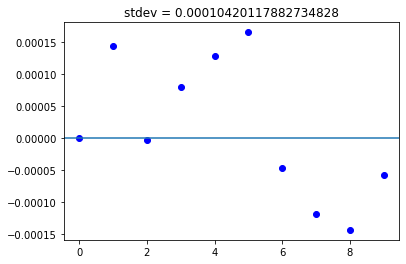

In [28]:
out2 = minimize(A010_resid, out.params, args=([data_p,data_m]),method='least_squares')#,kws={'flist':True})#,method='least_squares')
out2.params.pretty_print()
final_resid2 = A010_resid(out.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid2, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid2.std()))
plt.show()
out2

(-1.0, 1.0)

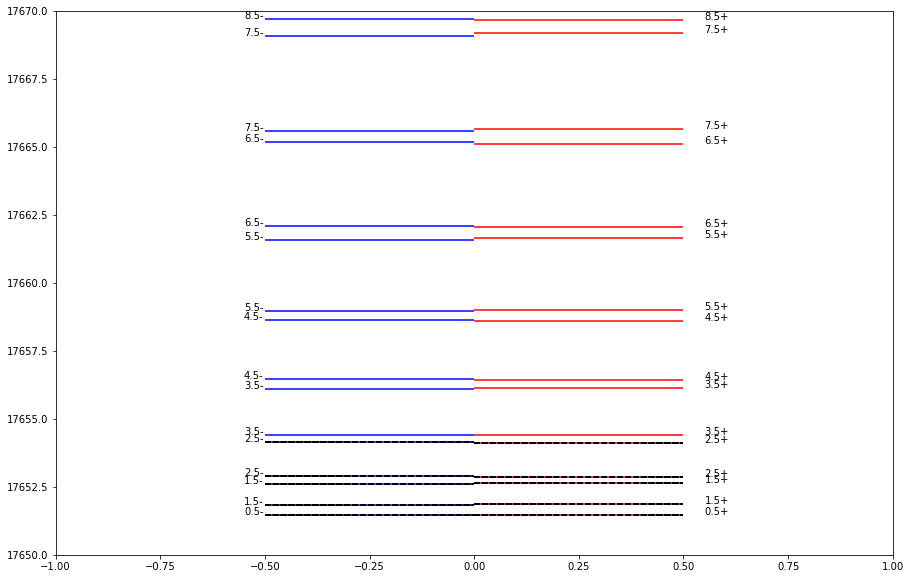

In [42]:
sub_B = False
fitparams = out2.params
plt.figure(figsize=(15,10))
depert = False
off=[]
for J in np.arange(1/2,16):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val+off[0])) for val in vals_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val+off[1])) for val in vals_m]

plt.ylim(17650,17670)
plt.xlim(-1,1)

In [ ]:
sub_B = False
fitparams = out2.params
plt.figure(figsize=(15,10))
depert = True
off=[]
for J in np.arange(1/2,16):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val+off[0])) for val in vals_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val+off[1])) for val in vals_m]

plt.ylim(17650,17670)
plt.xlim(-1,1)

(-1.0, 1.0)

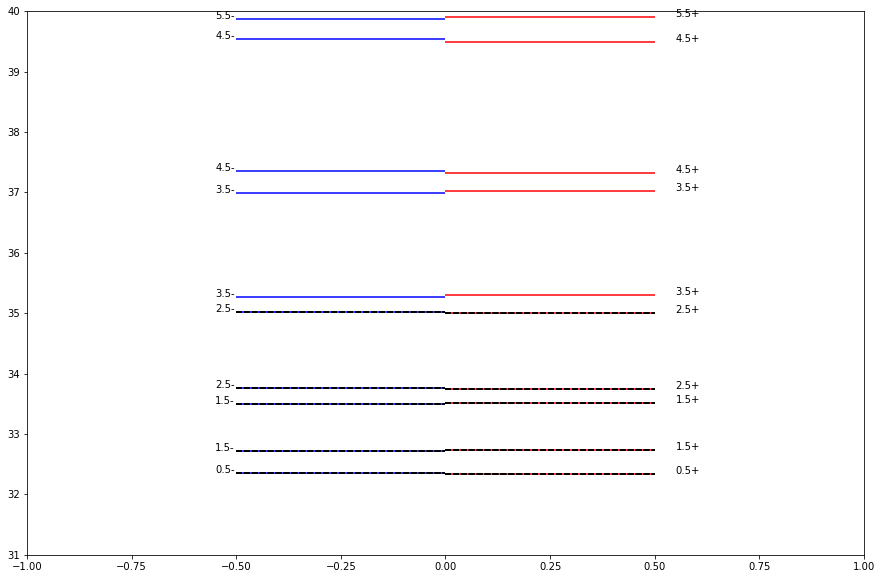

In [40]:
sub_B = False

plt.figure(figsize=(15,10))
off=[]
for J in np.arange(1/2,6):
    Hp = A010(J,1,out2.params)
    Hm = A010(J,-1,out2.params)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(vals_p),min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val,color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val)) for val in vals_p]
    [plt.hlines(y=val,color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p-min(data_p)+off[0],color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m-min(data_m)+off[1],color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val)) for val in vals_m]

plt.ylim(31,40)
plt.xlim(-1,1)

In [550]:
print(off)

[32.33262353639491, 32.349161803808585]


In [472]:
Hp = A010(3/2,1,out2.params)
Hm = A010(3/2,-1,out2.params)
vals_p,vecs_p = np.linalg.eigh(Hp)
vals_m,vecs_m = np.linalg.eigh(Hm)

In [477]:
Hp

array([[ 3.47432612e+01, -4.79406415e-01, -3.76885586e-01],
       [-4.79406415e-01,  1.28676705e+03, -2.39456630e+01],
       [-3.76885586e-01, -2.39456630e+01,  3.51714279e+01]])

In [473]:
vals_p

array([  34.34200614,   35.11454148, 1287.22519202])

In [487]:
vecs_p.T

array([[-6.93419125e-01, -1.40390276e-02, -7.20397684e-01],
       [-7.20534368e-01,  1.29876635e-02,  6.93297588e-01],
       [ 3.76941257e-04, -9.99817096e-01,  1.91214961e-02]])

In [471]:
vecs_m

array([[-0.0192932 , -0.99981387],
       [-0.99981387,  0.0192932 ]])

In [ ]:
params_A010_SrOH={
    'Ts':,
    'Td':,
    'Bd':,
    'Bs-':,
    'Bs+':,
    'Dd':0,
    'Ds-':0,
    'Ds+':0,
    'A':,
    'AD':0,
    'e':,
    'gs-':,
    'gs+':,
    'gsD-':,
    'gsD+':,
    'qe':,
    'qv':,
    'pe+2qe':,
    'w2':,
}

def A010_SrOH(J,parity,params):
    n=4
    Ts=0
    H = np.zeros((n,n))
    z=np.sqrt(J+1/2)
    Ad = params['A']*(1-3/4*params['e']**2)
    As = params['A']*(1-1/4*params['e']**2)
    AdD = params['AD']*(1-3/4*params['e']**2)
    AsD = params['AD']*(1-1/4*params['e']**2)
    H[0,0] = params['Ts']-params['Td']+params['Bd']*(z-6)-params['Dd'] (z**2-11*z+32)+1/2*(Ad+AdD*(z-6))
    H[0,1] = -params['Bd']*np.sqrt(z-4)+2*params['Dd']*(z-4)**(3/2)
    H[1,0] = H[0,1]
    H[1,1] = params['Ts'] - params['Td'] + params['Bd']*(z-2) - params['Dd']*z*(z-3)-1/2*(Ad+AdD*(z-2))
    H[0,2] = 1/2*params['qv']*(z**2-5*z+4)**(1/2)
    H[2,0] = H[0,2]
    H[1,2] = (z-1)**(1/2)*(parity*1/2*(params['qe']*z**(1/2)-params['qv']))
    H[2,1] = H[1,2]
    H[2,2] = params['Ts'] - 1/2*(As+AsD*z) - parity*1/2*params['gs-']*z**(1/2)+params['Bs-']*z-params['Ds-']*z*(z+1)-parity*params['gs-D']*z**(1/2)*(z+1+parity*z**(1/2))
    H[0,3] = parity*params['qe']*(z**2 - 5*z + 4)**(1/2)
    H[3,0] = H[0,3]
    H[1,3] = (z-1)**(1/2)*(-parity/2*params['pe+2qe']+1/2*params['qv']*z**(1/2))
    H[3,1] = H[1,3]
    H[2,3] = -1/2*(params['Bs-']+params['Bs+'])*z**(1/2) + (params['Ds-']+params['Ds+'])*z**(3/2)+params['e']*params['w2']
    H[3,2] = H[2,3]
    H[3,3] = params['Ts'] - 1/2*(As+AsD*z)+parity*params['gs+']*z**(1/2)+params['Bs+']*z - params['Ds+']*z*(z+1)+parity/2*params['gs+d']*z**(1/2)*(z+1-parity*2*z**(1/2))
    return H